In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class EfficientViT(nn.Module):
    def __init__(self,
                 img_size=32,
                 patch_size=8,
                 in_channels=3,
                 num_classes=10,
                 embed_dim=192,      # Reduced from 384
                 depth=4,            # Reduced from 6
                 num_heads=4,        # Reduced from 6
                 mlp_ratio=2):       # Reduced from 4
        super().__init__()

        # Calculate number of patches
        self.num_patches = (img_size // patch_size) ** 2

        # Patch embedding with reduced dimensionality
        self.patch_embed = nn.Conv2d(in_channels, embed_dim,
                                   kernel_size=patch_size,
                                   stride=patch_size)

        # Reduced size positional embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Lightweight transformer blocks
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # Simple classification head
        self.head = nn.Linear(embed_dim, num_classes)

        # Initialize weights
        self.initialize_weights()

    def initialize_weights(self):
        nn.init.normal_(self.pos_embed, std=0.02)
        nn.init.normal_(self.cls_token, std=0.02)

    def forward(self, x):
        # Create patches
        x = self.patch_embed(x)

        # Reshape and flatten patches
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]

        # Add class token
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        # Add position embeddings
        x = x + self.pos_embed

        # Transform
        x = self.transformer(x)

        # Classify using CLS token
        x = self.head(x[:, 0])
        return x

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        if batch_idx % 50 == 49:
            print(f'Batch: {batch_idx + 1}, Loss: {running_loss / 50:.3f}, '
                  f'Acc: {100. * correct / total:.2f}%')
            running_loss = 0.0

def main():
    # Hyperparameters optimized for Colab
    batch_size = 32      # Reduced from 64
    num_epochs = 5       # Reduced from 10

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Data loading
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = datasets.CIFAR10(root='./data', train=True,
                               download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size,
                           shuffle=True, num_workers=2)

    # Model, loss, and optimizer
    model = EfficientViT().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(),
                                lr=1e-3,
                                weight_decay=0.01)  # Adjusted for stability

    # Training loop
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        train_epoch(model, trainloader, criterion, optimizer, device)

    print('Training finished')

    # Save the model
    torch.save(model.state_dict(), 'efficient_vit.pth')

if __name__ == '__main__':
    main()

100%|██████████| 170M/170M [00:04<00:00, 40.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Epoch 1/5
Batch: 50, Loss: 2.187, Acc: 19.56%
Batch: 100, Loss: 2.044, Acc: 21.44%
Batch: 150, Loss: 2.039, Acc: 22.40%
Batch: 200, Loss: 2.019, Acc: 22.56%
Batch: 250, Loss: 2.006, Acc: 23.39%
Batch: 300, Loss: 2.011, Acc: 23.60%
Batch: 350, Loss: 1.992, Acc: 24.03%
Batch: 400, Loss: 1.939, Acc: 24.31%
Batch: 450, Loss: 1.949, Acc: 24.58%
Batch: 500, Loss: 1.942, Acc: 24.80%
Batch: 550, Loss: 1.940, Acc: 25.01%
Batch: 600, Loss: 1.945, Acc: 25.18%
Batch: 650, Loss: 1.946, Acc: 25.36%
Batch: 700, Loss: 1.948, Acc: 25.60%
Batch: 750, Loss: 1.946, Acc: 25.70%
Batch: 800, Loss: 2.007, Acc: 25.57%
Batch: 850, Loss: 1.940, Acc: 25.57%
Batch: 900, Loss: 1.994, Acc: 25.59%
Batch: 950, Loss: 2.005, Acc: 25.42%
Batch: 1000, Loss: 1.982, Acc: 25.38%
Batch: 1050, Loss: 2.034, Acc: 25.28%
Batch: 1100, Loss: 2.073, Acc: 25.12%
Batch: 1150, Loss: 2.074, Acc: 24.92%
Batch: 1200, Loss: 2.042, Acc: 24.84%
Batch: 1250, Loss: 2.128, Acc: 24.65%
Batch: 13

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import math

class ImprovedViT(nn.Module):
    def __init__(self,
                 img_size=32,
                 patch_size=8,
                 in_channels=3,
                 num_classes=10,
                 embed_dim=128,      # Further reduced
                 depth=3,            # Reduced depth
                 num_heads=4,
                 mlp_ratio=2):
        super().__init__()

        self.num_patches = (img_size // patch_size) ** 2

        # Improved patch embedding
        self.patch_embed = nn.Sequential(
            nn.Conv2d(in_channels, embed_dim, patch_size, patch_size),
            nn.LayerNorm([embed_dim, img_size // patch_size, img_size // patch_size])
        )

        # Position embedding with sine-cosine
        self.pos_embed = self.create_pos_embed(self.num_patches + 1, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Dropout for regularization
        self.dropout = nn.Dropout(0.1)

        # Transformer layers with pre-norm
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            dropout=0.1,
            batch_first=True,
            norm_first=True  # Pre-norm architecture
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # Classification head with layer norm
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        self.initialize_weights()

    def create_pos_embed(self, seq_len, dim):
        pos = torch.arange(seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * (-math.log(10000.0) / dim))
        pe = torch.zeros(1, seq_len, dim)
        pe[0, :, 0::2] = torch.sin(pos * div_term)
        pe[0, :, 1::2] = torch.cos(pos * div_term)
        return nn.Parameter(pe, requires_grad=False)

    def initialize_weights(self):
        # Better initialization
        nn.init.trunc_normal_(self.cls_token, std=0.02)

        # Initialize linear layers
        nn.init.xavier_uniform_(self.head.weight)
        nn.init.zeros_(self.head.bias)

    def forward(self, x):
        B = x.shape[0]

        # Create patches with normalization
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)

        # Add class token and position embedding
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed

        # Apply dropout
        x = self.dropout(x)

        # Transform
        x = self.transformer(x)

        # Normalize and classify
        x = self.norm(x[:, 0])
        x = self.head(x)
        return x

def train_epoch(model, loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        if batch_idx % 50 == 49:
            print(f'Batch: {batch_idx + 1}, Loss: {running_loss / 50:.3f}, '
                  f'Acc: {100. * correct / total:.2f}%')
            running_loss = 0.0

    scheduler.step()

def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Hyperparameters
    batch_size = 128  # Increased for better statistics
    num_epochs = 10   # Increased epochs

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Improved data augmentation
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                           (0.2023, 0.1994, 0.2010))  # CIFAR-10 specific stats
    ])

    trainset = datasets.CIFAR10(root='./data', train=True,
                               download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size,
                           shuffle=True, num_workers=2)

    model = ImprovedViT().to(device)

    # Improved loss with label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Improved optimizer with weight decay
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=3e-4,
        weight_decay=0.05,
        betas=(0.9, 0.999)
    )

    # Cosine learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=num_epochs
    )

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        train_epoch(model, trainloader, criterion, optimizer, scheduler, device)

    print('Training finished')
    torch.save(model.state_dict(), 'improved_vit.pth')

if __name__ == '__main__':
    main()

Files already downloaded and verified
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Batch: 50, Loss: 2.241, Acc: 19.81%
Batch: 100, Loss: 2.083, Acc: 22.13%
Batch: 150, Loss: 2.043, Acc: 23.57%
Batch: 200, Loss: 1.973, Acc: 25.14%
Batch: 250, Loss: 1.940, Acc: 26.43%
Batch: 300, Loss: 1.913, Acc: 27.47%
Batch: 350, Loss: 1.900, Acc: 28.41%
Epoch 2/10
Batch: 50, Loss: 1.865, Acc: 36.03%
Batch: 100, Loss: 1.865, Acc: 36.05%
Batch: 150, Loss: 1.854, Acc: 36.35%
Batch: 200, Loss: 1.842, Acc: 36.41%
Batch: 250, Loss: 1.834, Acc: 36.68%
Batch: 300, Loss: 1.801, Acc: 36.94%
Batch: 350, Loss: 1.815, Acc: 37.15%
Epoch 3/10
Batch: 50, Loss: 1.808, Acc: 38.94%
Batch: 100, Loss: 1.778, Acc: 39.64%
Batch: 150, Loss: 1.771, Acc: 39.92%
Batch: 200, Loss: 1.770, Acc: 40.27%
Batch: 250, Loss: 1.758, Acc: 40.67%
Batch: 300, Loss: 1.751, Acc: 40.91%
Batch: 350, Loss: 1.751, Acc: 41.01%
Epoch 4/10
Batch: 50, Loss: 1.734, Acc: 42.55%
Batch: 100, Loss: 1.741, Acc: 41.85%
Batch: 150, Loss: 1.729, Acc: 42.37%
Batch: 200, Loss: 1.715, Acc: 42.51%
Batch: 250, Loss: 1.716, Acc: 42.64%
Batch: 30

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import math
import numpy as np

class ImprovedViT(nn.Module):
    def __init__(self,
                 img_size=32,
                 patch_size=8,
                 in_channels=3,
                 num_classes=10,
                 embed_dim=192,
                 depth=4,
                 num_heads=6,
                 mlp_ratio=2):
        super().__init__()

        self.num_patches = (img_size // patch_size) ** 2

        # Improved patch embedding
        self.patch_embed = nn.Sequential(
            nn.Conv2d(in_channels, embed_dim, patch_size, patch_size),
            nn.LayerNorm([embed_dim, img_size // patch_size, img_size // patch_size])
        )

        # Position embedding with sine-cosine
        self.pos_embed = self.create_pos_embed(self.num_patches + 1, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Dropout for regularization
        self.dropout = nn.Dropout(0.1)

        # Transformer layers with pre-norm
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            dropout=0.1,
            batch_first=True,
            norm_first=True  # Pre-norm architecture
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # Classification head with layer norm
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        self.initialize_weights()

    def create_pos_embed(self, seq_len, dim):
        pos = torch.arange(seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * (-math.log(10000.0) / dim))
        pe = torch.zeros(1, seq_len, dim)
        pe[0, :, 0::2] = torch.sin(pos * div_term)
        pe[0, :, 1::2] = torch.cos(pos * div_term)
        return nn.Parameter(pe, requires_grad=False)

    def initialize_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.xavier_uniform_(self.head.weight)
        nn.init.zeros_(self.head.bias)

    def forward(self, x):
        B = x.shape[0]

        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)

        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed

        x = self.dropout(x)
        x = self.transformer(x)
        x = self.norm(x[:, 0])
        x = self.head(x)
        return x

def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def train_epoch(model, loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        # Apply mixup
        data, target_a, target_b, lam = mixup_data(data, target)

        optimizer.zero_grad()
        output = model(data)

        # Mixup loss
        loss = lam * criterion(output, target_a) + (1 - lam) * criterion(output, target_b)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += (lam * predicted.eq(target_a).float() +
                   (1 - lam) * predicted.eq(target_b).float()).sum().item()

        if batch_idx % 50 == 49:
            print(f'Batch: {batch_idx + 1}, Loss: {running_loss / 50:.3f}, '
                  f'Acc: {100. * correct / total:.2f}%')
            running_loss = 0.0
            correct = 0
            total = 0

def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    np.random.seed(42)

    # Hyperparameters
    batch_size = 128
    num_epochs = 10

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Enhanced data augmentation
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                           (0.2023, 0.1994, 0.2010))
    ])

    trainset = datasets.CIFAR10(root='./data', train=True,
                               download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size,
                           shuffle=True, num_workers=2)

    model = ImprovedViT().to(device)

    # Loss function with label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Optimizer with weight decay
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=3e-4,
        weight_decay=0.05,
        betas=(0.9, 0.999)
    )

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=3e-4,
        epochs=num_epochs,
        steps_per_epoch=len(trainloader),
        pct_start=0.2
    )

    print(f"Training on {device}")
    print(f"Number of training batches: {len(trainloader)}")

    try:
        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            train_epoch(model, trainloader, criterion, optimizer, scheduler, device)

            # Save checkpoint after each epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
            }, f'checkpoint_epoch_{epoch+1}.pth')

        print('Training finished')
        torch.save(model.state_dict(), 'final_improved_vit.pth')

    except KeyboardInterrupt:
        print('Training interrupted')
        torch.save(model.state_dict(), 'interrupted_improved_vit.pth')

if __name__ == '__main__':
    main()

Files already downloaded and verified
Training on cuda
Number of training batches: 391
Epoch 1/10
Batch: 50, Loss: 2.451, Acc: 13.11%
Batch: 100, Loss: 2.268, Acc: 17.57%
Batch: 150, Loss: 2.231, Acc: 18.65%
Batch: 200, Loss: 2.190, Acc: 20.48%
Batch: 250, Loss: 2.144, Acc: 21.16%
Batch: 300, Loss: 2.142, Acc: 22.54%
Batch: 350, Loss: 2.099, Acc: 24.35%
Epoch 2/10
Batch: 50, Loss: 2.052, Acc: 26.71%
Batch: 100, Loss: 2.040, Acc: 27.79%
Batch: 150, Loss: 2.036, Acc: 27.80%
Batch: 200, Loss: 1.992, Acc: 29.77%
Batch: 250, Loss: 1.989, Acc: 30.93%
Batch: 300, Loss: 1.971, Acc: 31.49%
Batch: 350, Loss: 1.986, Acc: 30.82%
Epoch 3/10
Batch: 50, Loss: 1.936, Acc: 34.08%
Batch: 100, Loss: 1.920, Acc: 34.62%
Batch: 150, Loss: 1.941, Acc: 33.51%
Batch: 200, Loss: 1.928, Acc: 33.61%
Batch: 250, Loss: 1.883, Acc: 35.66%
Batch: 300, Loss: 1.921, Acc: 35.26%
Batch: 350, Loss: 1.872, Acc: 37.07%
Epoch 4/10
Batch: 50, Loss: 1.895, Acc: 36.60%
Batch: 100, Loss: 1.875, Acc: 36.75%
Batch: 150, Loss: 1.85

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import math
import numpy as np

class LayerScale(nn.Module):
    def __init__(self, dim, init_values=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(init_values * torch.ones(dim))

    def forward(self, x):
        return x * self.gamma

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0

        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False,
                 drop=0., attn_drop=0., init_values=1e-5):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias,
                            attn_drop=attn_drop, proj_drop=drop)
        self.ls1 = LayerScale(dim, init_values=init_values)

        self.norm2 = nn.LayerNorm(dim)
        self.mlp = FeedForward(dim, int(dim * mlp_ratio), dropout=drop)
        self.ls2 = LayerScale(dim, init_values=init_values)

    def forward(self, x):
        x = x + self.ls1(self.attn(self.norm1(x)))
        x = x + self.ls2(self.mlp(self.norm2(x)))
        return x

class OptimizedViT(nn.Module):
    def __init__(self,
                 img_size=32,
                 patch_size=8,
                 in_channels=3,
                 num_classes=10,
                 embed_dim=256,      # Increased
                 depth=6,            # Increased
                 num_heads=8,        # Increased
                 mlp_ratio=4.,
                 qkv_bias=True,
                 drop_rate=0.1,
                 attn_drop_rate=0.1):
        super().__init__()

        self.num_patches = (img_size // patch_size) ** 2

        # Patch embedding with layer norm
        self.patch_embed = nn.Sequential(
            nn.Conv2d(in_channels, embed_dim, patch_size, patch_size),
            nn.LayerNorm([embed_dim, img_size // patch_size, img_size // patch_size])
        )

        # Learnable position embedding and class token
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Dropout
        self.pos_drop = nn.Dropout(drop_rate)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                init_values=1e-5 if i < depth//2 else 1e-6
            )
            for i in range(depth)
        ])

        # Final layer norm and classifier
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Dropout(drop_rate),
            nn.Linear(embed_dim, num_classes)
        )

        # Initialize weights
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize patch_embed
        nn.init.normal_(self.patch_embed[0].weight, std=.02)

        # Initialize position embedding
        nn.init.trunc_normal_(self.pos_embed, std=.02)

        # Initialize cls token
        nn.init.trunc_normal_(self.cls_token, std=.02)

        # Initialize head
        if isinstance(self.head, nn.Linear):
            nn.init.zeros_(self.head.bias)
            nn.init.xavier_uniform_(self.head.weight)

    def forward(self, x):
        # Patch embedding
        B = x.shape[0]
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)

        # Add class token and position embedding
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)

        # Classification
        x = self.norm(x)
        x = x[:, 0]
        x = self.head(x)
        return x

def train_epoch(model, loader, criterion, optimizer, scheduler, device, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            output = model(data)
            loss = criterion(output, target)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        if batch_idx % 50 == 49:
            print(f'Batch: {batch_idx + 1}, Loss: {running_loss / 50:.3f}, '
                  f'Acc: {100. * correct / total:.2f}%')
            running_loss = 0.0
            correct = 0
            total = 0

def main():
    # Set random seed
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    np.random.seed(42)

    # Hyperparameters
    batch_size = 64  # Reduced for stability
    num_epochs = 15  # Increased epochs

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Data augmentation and normalization
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandAugment(num_ops=2, magnitude=9),  # Added RandAugment
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                           (0.2023, 0.1994, 0.2010))
    ])

    trainset = datasets.CIFAR10(root='./data', train=True,
                               download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size,
                           shuffle=True, num_workers=2,
                           pin_memory=True)

    model = OptimizedViT().to(device)

    # Criterion with label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-3,
        weight_decay=0.05,
        betas=(0.9, 0.999)
    )

    # Scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=num_epochs,
        steps_per_epoch=len(trainloader),
        pct_start=0.1,
        anneal_strategy='cos'
    )

    # Automatic mixed precision
    scaler = torch.cuda.amp.GradScaler()

    print(f"Training on {device}")

    try:
        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            train_epoch(model, trainloader, criterion, optimizer, scheduler, device, scaler)

            # Save checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
            }, f'checkpoint_epoch_{epoch+1}.pth')

        print('Training finished')
        torch.save(model.state_dict(), 'final_optimized_vit.pth')

    except KeyboardInterrupt:
        print('Training interrupted')
        torch.save(model.state_dict(), 'interrupted_vit.pth')

if __name__ == '__main__':
    main()

Files already downloaded and verified
Training on cuda
Epoch 1/15


<ipython-input-5-f48f330ace98>:255: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-5-f48f330ace98>:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Batch: 50, Loss: 2.307, Acc: 11.72%
Batch: 100, Loss: 2.268, Acc: 13.75%
Batch: 150, Loss: 2.203, Acc: 16.69%
Batch: 200, Loss: 2.182, Acc: 18.16%
Batch: 250, Loss: 2.146, Acc: 19.75%
Batch: 300, Loss: 2.107, Acc: 23.22%
Batch: 350, Loss: 2.079, Acc: 23.84%
Batch: 400, Loss: 2.071, Acc: 25.69%
Batch: 450, Loss: 2.061, Acc: 25.06%
Batch: 500, Loss: 2.043, Acc: 25.78%
Batch: 550, Loss: 2.061, Acc: 24.97%
Batch: 600, Loss: 2.050, Acc: 25.84%
Batch: 650, Loss: 2.012, Acc: 27.25%
Batch: 700, Loss: 2.010, Acc: 27.66%
Batch: 750, Loss: 2.010, Acc: 26.53%
Epoch 2/15
Batch: 50, Loss: 2.006, Acc: 27.94%
Batch: 100, Loss: 2.014, Acc: 28.31%
Batch: 150, Loss: 1.996, Acc: 28.44%
Batch: 200, Loss: 2.015, Acc: 28.06%
Batch: 250, Loss: 1.974, Acc: 29.84%
Batch: 300, Loss: 1.998, Acc: 30.38%
Batch: 350, Loss: 1.982, Acc: 28.16%
Batch: 400, Loss: 1.973, Acc: 29.22%
Batch: 450, Loss: 1.986, Acc: 29.09%
Batch: 500, Loss: 1.975, Acc: 29.66%
Batch: 550, Loss: 1.959, Acc: 31.84%
Batch: 600, Loss: 1.937, Acc:

<ipython-input-6-40f4c44daa33>:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('final_optimized_vit.pth'))


Files already downloaded and verified
Overall Accuracy: 57 %

Per-class Accuracy:
Accuracy of plane : 68 %
Accuracy of   car : 65 %
Accuracy of  bird : 45 %
Accuracy of   cat : 31 %
Accuracy of  deer : 38 %
Accuracy of   dog : 50 %
Accuracy of  frog : 72 %
Accuracy of horse : 65 %
Accuracy of  ship : 74 %
Accuracy of truck : 64 %


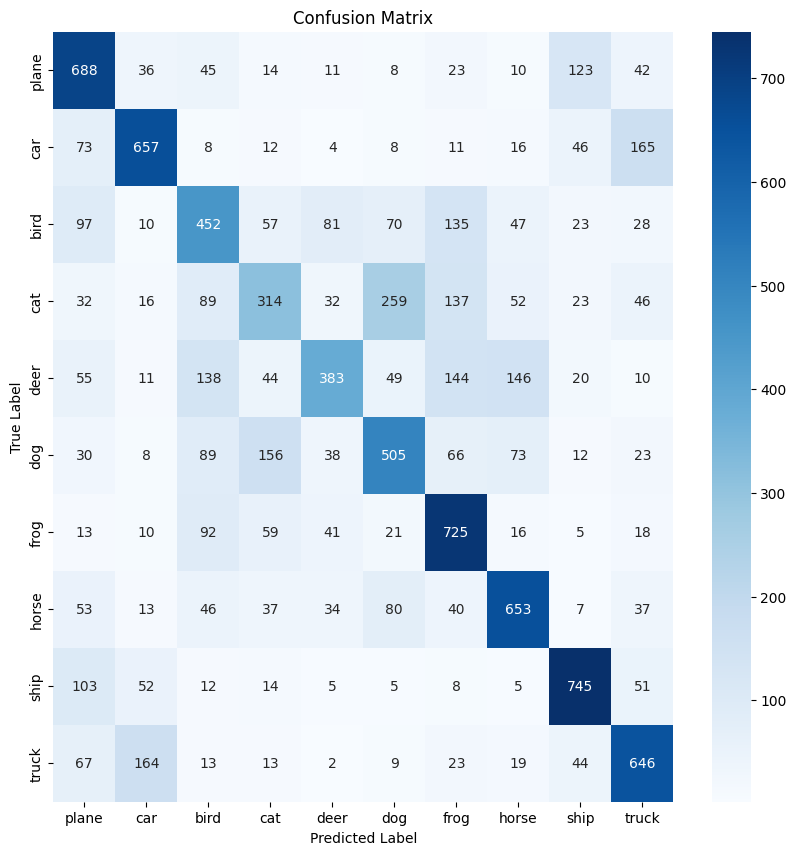


Classification Report:
              precision    recall  f1-score   support

       plane       0.57      0.69      0.62      1000
         car       0.67      0.66      0.66      1000
        bird       0.46      0.45      0.46      1000
         cat       0.44      0.31      0.37      1000
        deer       0.61      0.38      0.47      1000
         dog       0.50      0.51      0.50      1000
        frog       0.55      0.72      0.63      1000
       horse       0.63      0.65      0.64      1000
        ship       0.71      0.74      0.73      1000
       truck       0.61      0.65      0.63      1000

    accuracy                           0.58     10000
   macro avg       0.57      0.58      0.57     10000
weighted avg       0.57      0.58      0.57     10000



In [6]:
def evaluate_model(model, device):
    # Data preparation for test set
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                           (0.2023, 0.1994, 0.2010))
    ])

    testset = datasets.CIFAR10(root='./data', train=False,
                              download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=100,
                          shuffle=False, num_workers=2)

    # Classes in CIFAR-10
    classes = ('plane', 'car', 'bird', 'cat',
              'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # Evaluation mode
    model.eval()

    # Initialize metrics
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    # For confusion matrix
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # Overall accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Print overall accuracy
    print('Overall Accuracy: %d %%' % (100 * correct / total))

    # Print per-class accuracy
    print('\nPer-class Accuracy:')
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

    # Create confusion matrix
    confusion_mtx = confusion_matrix(all_targets, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10,10))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Calculate and print classification report
    print('\nClassification Report:')
    print(classification_report(all_targets, all_preds,
                              target_names=classes))

# Usage:
if __name__ == "__main__":
    import torch
    from torchvision import transforms, datasets
    from torch.utils.data import DataLoader
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, classification_report

    # Load your trained model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = OptimizedViT().to(device)
    model.load_state_dict(torch.load('final_optimized_vit.pth'))

    # Evaluate
    evaluate_model(model, device)